## Load libraries

In [50]:
# Libraries to work cross-platform
import os

# Libraries to work with dataset
import numpy as np
import pandas as pd
import ast                      # convert string to list after importing csv data
import tmtoolkit
import pickle

# Libraries to cluster data
from gsdmm import MovieGroupProcess

# Libraries to visualize data
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
from cluster_visualization_helper import (
    visualize_cluster  # user-defined functions
)

# Libraries for evaluation
from sklearn import metrics

# Libraries for monitoring operation process
from tqdm import tqdm
from datetime import datetime
# from pprint import pprint
# import logging

## Configurate and declare global variables

In [2]:
os_name = os.name

if os_name == 'nt':
    BASE_DIR = "E:/THIENDHB_GOOGLEDRIVE/MASTER TILBURG/THESIS/"
    INPUT_DIR = BASE_DIR + "DATASET/INPUT/"
    OUTPUT_DIR = BASE_DIR + "DATASET/OUTPUT/"
elif os_name == 'posix':
    BASE_DIR = "/media/pinkalinux/WORK/THIENDHB_GOOGLEDRIVE/MASTER TILBURG/THESIS/"
    INPUT_DIR = BASE_DIR + "DATASET/INPUT/"
    OUTPUT_DIR = BASE_DIR + "DATASET/OUTPUT/"

SEED = 6886

%matplotlib inline

## Import data

In [3]:
skill_embeddings = np.load(OUTPUT_DIR + "skill_feat_embeddings.npy")
skill_embeddings.shape

(361584, 600)

In [4]:
skill_docs = pd.read_csv(
    OUTPUT_DIR + "skill_tokens_long_df.csv",
    converters={
        "skill_description_tokens": ast.literal_eval,
        "skill_requirement_tokens": ast.literal_eval,
        "skill_qualification_tokens": ast.literal_eval
    },
    dtype={
        "skill_id": int,
        "job_id": int,
        "job_description": str,
        "job_requirement": str,
        "job_qualification": str
    }
)
skill_docs.shape

(361584, 8)

In [5]:
skill_docs.iloc[:5, ]

,skill_id,job_id,job_description,skill_description_tokens,job_requirement,skill_requirement_tokens,job_qualification,skill_qualification_tokens
0,1,1,ameria investment consulting company,"[ameria, investment, consulting, company]",liquidity reserves assists investment team,"[liquidity, reserves, assists, investment, team]",providing job performance feedback,"[providing, job, performance, feedback]"
1,2,1,provides highly responsible,"[provides, highly, responsible]",incorporation regarding corporate registration,"[incorporation, regarding, corporate, registra...",operate specialized software applications,"[operate, specialized, software, applications]"
2,3,1,complex staff assistance,"[complex, staff, assistance]",including evaluating loss exposure,"[including, evaluating, loss, exposure]",state reporting requirements pertaining,"[state, reporting, requirements, pertaining]"
3,4,1,chief financial officer,"[chief, financial, officer]",internal financial management reports,"[internal, financial, management, reports]",generally accepted accounting principles,"[generally, accepted, accounting, principles]"
4,5,1,investment management,"[investment, management]",investment team leader,"[investment, team, leader]",accounting technical skills coupled,"[accounting, technical, skills, coupled]"


## Clustering data

### Gibbs Sampling Dirichlet Mixture Model (GSDMM)

In [6]:
skill_docs["feature_skills_tokens"] = (
    skill_docs["skill_description_tokens"] + skill_docs["skill_requirement_tokens"]
)
skill_docs.iloc[:5, ]

,skill_id,job_id,job_description,skill_description_tokens,job_requirement,skill_requirement_tokens,job_qualification,skill_qualification_tokens,feature_skills_tokens
0,1,1,ameria investment consulting company,"[ameria, investment, consulting, company]",liquidity reserves assists investment team,"[liquidity, reserves, assists, investment, team]",providing job performance feedback,"[providing, job, performance, feedback]","[ameria, investment, consulting, company, liqu..."
1,2,1,provides highly responsible,"[provides, highly, responsible]",incorporation regarding corporate registration,"[incorporation, regarding, corporate, registra...",operate specialized software applications,"[operate, specialized, software, applications]","[provides, highly, responsible, incorporation,..."
2,3,1,complex staff assistance,"[complex, staff, assistance]",including evaluating loss exposure,"[including, evaluating, loss, exposure]",state reporting requirements pertaining,"[state, reporting, requirements, pertaining]","[complex, staff, assistance, including, evalua..."
3,4,1,chief financial officer,"[chief, financial, officer]",internal financial management reports,"[internal, financial, management, reports]",generally accepted accounting principles,"[generally, accepted, accounting, principles]","[chief, financial, officer, internal, financia..."
4,5,1,investment management,"[investment, management]",investment team leader,"[investment, team, leader]",accounting technical skills coupled,"[accounting, technical, skills, coupled]","[investment, management, investment, team, lea..."


In [7]:
skill_corpus = skill_docs["feature_skills_tokens"].values.tolist()
skill_vocab = set(tmtoolkit.utils.flatten_list(skill_corpus))
len(skill_vocab), list(skill_vocab)[:10]

(15037,
 ['sterilization',
  'cutting',
  'postgraduate',
  'sport',
  'played',
  'repetitive',
  'domino',
  'chart',
  'finalist',
  'seeks'])

In [8]:
def build_mgp_model(
    X,
    corpus,
    vocab_size,
    K=100,
    alpha=0.1,
    beta=0.1,
    n_iters=50,
    seed=SEED,
):
    """
    A MovieGroupProcess is a conceptual model introduced by Yin and Wang 2014 to
    describe their Gibbs sampling algorithm for a Dirichlet Mixture Model for the
    clustering short text documents.
    Reference: http://dbgroup.cs.tsinghua.edu.cn/wangjy/papers/KDD14-GSDMM.pdf
    Imagine a professor is leading a film class. At the start of the class, the students
    are randomly assigned to K tables. Before class begins, the students make lists of
    their favorite films. The teacher reads the role n_iters times. When
    a student is called, the student must select a new table satisfying either:
        1) The new table has more students than the current table.
    OR
        2) The new table has students with similar lists of favorite movies.

    :param K: int
        Upper bound on the number of possible clusters. Typically many fewer
    :param alpha: float between 0 and 1
        Alpha controls the probability that a student will join a table that is currently empty
        When alpha is 0, no one will join an empty table.
    :param beta: float between 0 and 1
        Beta controls the student's affinity for other students with similar interests. A low beta means
        that students desire to sit with students of similar interests. A high beta means they are less
        concerned with affinity and are more influenced by the popularity of a table
    """

#     logging.debug("Start of GSDMM model for job titles")

    np.random.seed(SEED)
    mgp = MovieGroupProcess(K=K, alpha=alpha, beta=beta, n_iters=n_iters)

    """
        MovieGroupProcess().fit: Cluster the input documents
        :param docs: list of list
            list of lists containing the unique token set of each document
        :param V: total vocabulary size for each document
        :return: list of length len(doc)
            cluster label for each document
    """
    mgp_labels = mgp.fit(docs=corpus, vocab_size=vocab_size)

#     logging.debug("End of GSDMM model for job titles")

    return mgp, mgp_labels

## Tuning hyperparameters

In [12]:
# Define search parameters
# k_range = [50, 100, 150]
# alpha_range = [0.01, 0.25, 0.5, 0.75, 1.0]
# beta_range = [0.01, 0.25, 0.5, 0.75, 1.0]
# n_iter_range = [50, 100]
k_range = [150]
alpha_range = [0.01, 0.2]
beta_range = [0.01, 0.2]
n_iter_range = [10]

print(
    "Total hyperparameters in search space =",
    str(len(k_range) * len(alpha_range) * len(beta_range) * len(n_iter_range)),
)

Total hyperparameters in search space = 4


In [13]:
# Create empty list to store labels created by models
labels_list = []
model_list = []
duration_list = []
model_result = {"K": [], "alpha": [], "beta": [], "n_iters": [], "Silhouette": []}

start_loop_time = datetime.now()
print(f"Start loop {start_loop_time.strftime('%Y-%m-%d %H:%M:%S.%f')}")

# Loop through the search space
tqdm_bar = tqdm(
    desc="Tuning GSDMM model",
    total=len(k_range) * len(alpha_range) * len(beta_range) * len(n_iter_range),
)

for K in k_range:
    for alpha in alpha_range:
        for beta in beta_range:
            for n_iters in n_iter_range:
                print(f"K = {K}")
                print(f"alpha = {alpha}")
                print(f"beta = {beta}")
                print(f"n_iters = {n_iters}")

                starttime = datetime.now()
                print(f"Start {starttime.strftime('%Y-%m-%d %H:%M:%S.%f')}")

                mgp_model, mgp_labels = build_mgp_model(
                    X=skill_docs,
                    corpus=skill_corpus,
                    vocab_size=len(skill_vocab),
                    K=K,
                    alpha=alpha,
                    beta=beta,
                    n_iters=n_iters,
                    seed=SEED,
                )

                endtime = datetime.now()
                print(f"End {endtime.strftime('%Y-%m-%d %H:%M:%S.%f')}")
                print(f"Duration {endtime - starttime}")

                duration_list.append(round((endtime - starttime).seconds / 60, 2))
                labels_list.append(mgp_labels)
                model_list.append(mgp_model)

                model_result["K"].append(K)
                model_result["alpha"].append(alpha)
                model_result["beta"].append(beta)
                model_result["n_iters"].append(n_iters)

                # Save model
                pickle.dump(
                    (mgp_model, mgp_labels),
                    open(
                        OUTPUT_DIR
                        + "gsdmm/"
                        + "skills_gsdmm_tuning_results_"
                        + "_K-"
                        + str(K)
                        + "_alpha-"
                        + str(alpha)
                        + "_beta-"
                        + str(beta)
                        + "_niters-"
                        + str(n_iters)
                        + ".pkl",
                        "wb",
                    ),
                )

                tqdm_bar.update(1)

tqdm_bar.close()

end_loop_time = datetime.now()
print(f"End loop {end_loop_time.strftime('%Y-%m-%d %H:%M:%S.%f')}")
print(f"Duration {end_loop_time - start_loop_time}")


Tuning GSDMM model:   0%|                                                                        | 0/4 [00:00<?, ?it/s]

Start loop 2021-05-04 23:31:17.884420
K = 150
alpha = 0.01
beta = 0.01
n_iters = 10
Start 2021-05-04 23:31:17.887417
In stage 0: transferred 352872 clusters with 150 clusters populated
In stage 1: transferred 309011 clusters with 150 clusters populated
In stage 2: transferred 268306 clusters with 150 clusters populated
In stage 3: transferred 241809 clusters with 150 clusters populated
In stage 4: transferred 226250 clusters with 150 clusters populated
In stage 5: transferred 216142 clusters with 150 clusters populated
In stage 6: transferred 207832 clusters with 150 clusters populated
In stage 7: transferred 201608 clusters with 150 clusters populated
In stage 8: transferred 196035 clusters with 150 clusters populated



Tuning GSDMM model:  25%|██████████████▌                                           | 1/4 [1:17:32<3:52:37, 4652.36s/it]

In stage 9: transferred 191090 clusters with 150 clusters populated
End 2021-05-05 00:48:50.215623
Duration 1:17:32.328206
K = 150
alpha = 0.01
beta = 0.2
n_iters = 10
Start 2021-05-05 00:48:50.246841
In stage 0: transferred 356825 clusters with 150 clusters populated
In stage 1: transferred 331893 clusters with 150 clusters populated
In stage 2: transferred 288390 clusters with 150 clusters populated
In stage 3: transferred 249933 clusters with 150 clusters populated
In stage 4: transferred 224122 clusters with 149 clusters populated
In stage 5: transferred 207748 clusters with 144 clusters populated
In stage 6: transferred 196231 clusters with 136 clusters populated
In stage 7: transferred 189172 clusters with 123 clusters populated
In stage 8: transferred 184236 clusters with 114 clusters populated



Tuning GSDMM model:  50%|█████████████████████████████                             | 2/4 [2:33:15<2:32:56, 4588.33s/it]

In stage 9: transferred 180991 clusters with 108 clusters populated
End 2021-05-05 02:04:33.720920
Duration 1:15:43.474079
K = 150
alpha = 0.2
beta = 0.01
n_iters = 10
Start 2021-05-05 02:04:33.752194
In stage 0: transferred 352872 clusters with 150 clusters populated
In stage 1: transferred 309011 clusters with 150 clusters populated
In stage 2: transferred 268404 clusters with 150 clusters populated
In stage 3: transferred 241588 clusters with 150 clusters populated
In stage 4: transferred 225620 clusters with 150 clusters populated
In stage 5: transferred 215539 clusters with 150 clusters populated
In stage 6: transferred 207536 clusters with 150 clusters populated
In stage 7: transferred 201608 clusters with 150 clusters populated
In stage 8: transferred 196885 clusters with 150 clusters populated



Tuning GSDMM model:  75%|███████████████████████████████████████████▌              | 3/4 [3:49:50<1:16:31, 4591.38s/it]

In stage 9: transferred 192321 clusters with 150 clusters populated
End 2021-05-05 03:21:08.734401
Duration 1:16:34.982207
K = 150
alpha = 0.2
beta = 0.2
n_iters = 10
Start 2021-05-05 03:21:08.765684
In stage 0: transferred 356939 clusters with 150 clusters populated
In stage 1: transferred 330368 clusters with 150 clusters populated
In stage 2: transferred 286548 clusters with 150 clusters populated
In stage 3: transferred 250368 clusters with 150 clusters populated
In stage 4: transferred 226521 clusters with 150 clusters populated
In stage 5: transferred 210893 clusters with 146 clusters populated
In stage 6: transferred 200165 clusters with 137 clusters populated
In stage 7: transferred 192298 clusters with 120 clusters populated
In stage 8: transferred 186251 clusters with 115 clusters populated



Tuning GSDMM model: 100%|████████████████████████████████████████████████████████████| 4/4 [5:07:00<00:00, 4605.06s/it]

In stage 9: transferred 179915 clusters with 101 clusters populated
End 2021-05-05 04:38:18.130678
Duration 1:17:09.364994
End loop 2021-05-05 04:38:18.146319
Duration 5:07:00.261899


## Evaluate clustering performance

In [58]:
# Calculate Silhouette score
model_result["Silhouette"] = [0] * 4

for idx in tqdm(range(len(model_list))):
    silho_score = metrics.silhouette_score(
        skill_embeddings,
        labels_list[idx],
        sample_size=30000,
        random_state=SEED,
        n_jobs=-1,
    )
    model_result["Silhouette"][idx] = silho_score

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [02:25<00:00, 36.32s/it]


In [16]:
def get_average_score(models, docs):
    avg_score_list = []
    for model in models:
        score_list = []
        for doc in docs:
            score = model.score(doc)
            score_list.append(score)
#             print(score_list)
            avg_score = np.mean(score_list)
#             print(avg_score)
        avg_score_list.append(avg_score)
    return avg_score_list

In [17]:
# Create average score
avg_scores = get_average_score(model_list, skill_docs)
# print(avg_scores)
model_result['Average Score'] = avg_scores

In [59]:
model_result_df = pd.DataFrame(model_result)
model_result_df

,K,alpha,beta,n_iters,Silhouette,Average Score
0,150,0.01,0.01,10,-0.111017,0.006667
1,150,0.01,0.20,10,-0.156729,0.006667
2,150,0.20,0.01,10,-0.118895,0.006667
3,150,0.20,0.20,10,-0.124757,0.006667


In [60]:
# Save tuning results to file
model_result_df.to_csv(
    OUTPUT_DIR + "gsdmm/" + "job-skills_gsdmm-tuning-results.csv", index=False
)

In [61]:
# Combine model sets
tuple_objects = (
    k_range,
    alpha_range,
    beta_range,
    model_list,
    duration_list,
    labels_list,
    model_result_df
)
len(tuple_objects), len(tuple_objects[0])

(7, 1)

In [62]:
# Save tuple
pickle.dump(tuple_objects, open(OUTPUT_DIR + "gsdmm/" + "skills_gsdmm_tuning_results.pkl", "wb"))

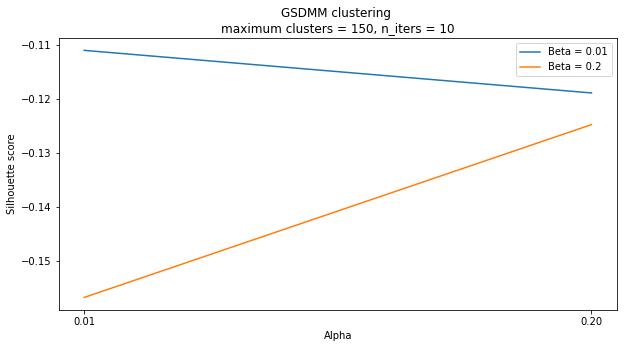

In [63]:
# Plot the Silhouette score
plt.figure(figsize=(10, 5))
for idb, b in enumerate(beta_range):
    plt.plot(
        model_result_df["alpha"].loc[model_result_df["beta"] == b],
        model_result_df["Silhouette"].loc[model_result_df["beta"] == b],
        label=f"Beta = {b}",
    )
    plt.title(
        "GSDMM clustering \n"
        + "maximum clusters = "
        + str(int(model_result_df.loc[0, ["K"]]))
        + ", n_iters = "
        + str(int(model_result_df.loc[0, ["n_iters"]]))
    )
    plt.legend(loc="best")
    plt.xlabel("Alpha")
    plt.xticks(alpha_range)
    plt.ylabel("Silhouette score")
    plt.grid()
plt.show()

In [29]:
# Read the log info of training passes
training_df = pd.read_csv(OUTPUT_DIR + 'gsdmm/skills_gsdmm_training_results.csv')
training_df.head(5)

,pass,K,alpha,beta,n_iters,duration,start_time,end_time,transfered_clusters,number_clusters
0,0,150,0.01,0.01,10,1:17:32.328206,2021-05-04 23:31:17.887417,2021-05-05 00:48:50.215623,352872,150
1,1,150,0.01,0.01,10,1:17:32.328206,2021-05-04 23:31:17.887417,2021-05-05 00:48:50.215623,309011,150
2,2,150,0.01,0.01,10,1:17:32.328206,2021-05-04 23:31:17.887417,2021-05-05 00:48:50.215623,268306,150
3,3,150,0.01,0.01,10,1:17:32.328206,2021-05-04 23:31:17.887417,2021-05-05 00:48:50.215623,241809,150
4,4,150,0.01,0.01,10,1:17:32.328206,2021-05-04 23:31:17.887417,2021-05-05 00:48:50.215623,226250,150


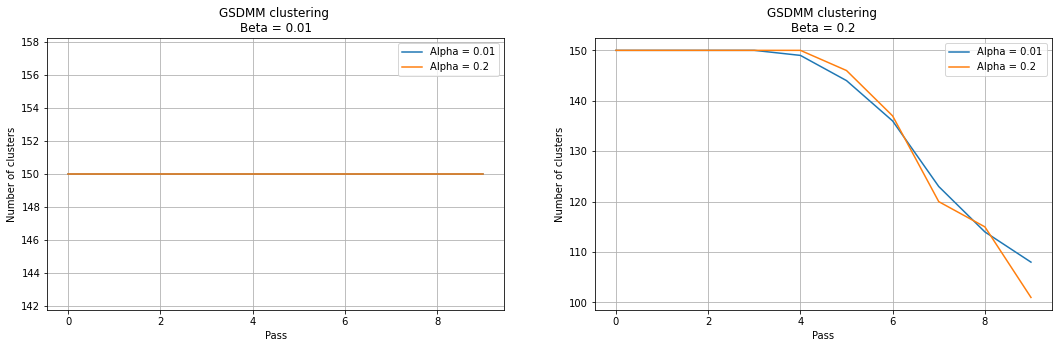

In [27]:
# Plot the number of cluster during training passes
plt.figure(figsize=(18, 5))
for idb, b in enumerate(beta_range):
    plot_df = training_df.loc[training_df["beta"] == b]
    plt.subplot(1, len(beta_range), idb+1)
    for ida, a in enumerate(alpha_range):
        plt.plot(
            plot_df["pass"].loc[plot_df["alpha"] == a],
            plot_df["number_clusters"].loc[plot_df["alpha"] == a],
            label=f"Alpha = {a}",
        )
    plt.title(
        "GSDMM clustering \n"
        + "Beta = " + str(b)
    )
    plt.legend(loc="best")
    plt.xlabel("Pass")
#     plt.xticks(np.unique(training_df['pass']))
    plt.ylabel("Number of clusters")
    plt.grid()
plt.show()

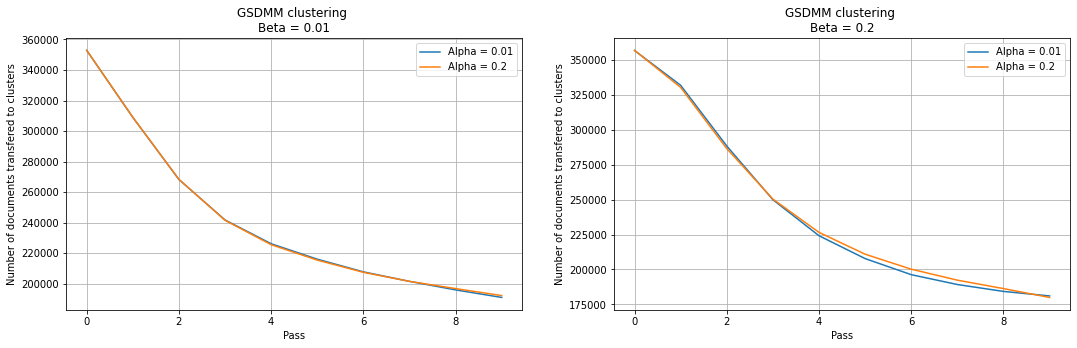

In [28]:
# Plot the number of cluster during training passes
plt.figure(figsize=(18, 5))
for idb, b in enumerate(beta_range):
    plot_df = training_df.loc[training_df["beta"] == b]
    plt.subplot(1, len(beta_range), idb+1)
    for ida, a in enumerate(alpha_range):
        plt.plot(
            plot_df["pass"].loc[plot_df["alpha"] == a],
            plot_df["transfered_clusters"].loc[plot_df["alpha"] == a],
            label=f"Alpha = {a}",
        )
    plt.title(
        "GSDMM clustering \n"
        + "Beta = " + str(b)
    )
    plt.legend(loc="best")
    plt.xlabel("Pass")
#     plt.xticks(np.unique(training_df['pass']))
    plt.ylabel("Number of documents transfered to clusters")
    plt.grid()
plt.show()

In [64]:
# Select best model base on Silhouette score
best_index = np.argmax(model_result["Silhouette"])
best_n = len(np.unique(labels_list[best_index]))
best_model = model_list[best_index]
best_labels = labels_list[best_index]
best_params = [(key, value[best_index]) for key, value in model_result.items()]
best_index, best_params

(0,
 [('K', 150),
  ('alpha', 0.01),
  ('beta', 0.01),
  ('n_iters', 10),
  ('Silhouette', -0.11101740378869102),
  ('Average Score', 0.006666666666666667)])

In [ ]:
# tmp_model, tmp_labels = build_mgp_model(
#     X=skill_docs,
#     corpus=skill_corpus,
#     vocab_size=len(skill_vocab),
#     K=100,
#     alpha=0.5,
#     beta=0.2,
#     n_iters=20,
#     seed=SEED,
# )

In [66]:
# import gc
# gc.collect()

22

In [69]:
%whos

Variable              Type                 Data/Info
----------------------------------------------------
BASE_DIR              str                  E:/THIENDHB_GOOGLEDRIVE/MASTER TILBURG/THESIS/
INPUT_DIR             str                  E:/THIENDHB_GOOGLEDRIVE/M<...>URG/THESIS/DATASET/INPUT/
K                     int                  150
MovieGroupProcess     type                 <class 'gsdmm.mgp.MovieGroupProcess'>
OUTPUT_DIR            str                  E:/THIENDHB_GOOGLEDRIVE/M<...>RG/THESIS/DATASET/OUTPUT/
SEED                  int                  6886
a                     float                0.2
alpha                 float                0.2
alpha_range           list                 n=2
ast                   module               <module 'ast' from 'c:\\u<...>\\python38\\lib\\ast.py'>
avg_scores            list                 n=4
b                     float                0.2
best_index            int64                0
best_labels           list                 n=361584

## Visualize clustering result

In [54]:
pca_datapoint = np.load(OUTPUT_DIR + "visualization/" + "skills_wide_pca_datapoints.npy")
tsne_datapoint = np.load(OUTPUT_DIR + "visualization/" + "skills_wide_tsne_datapoints.npy")

Start PCA 2021-05-05 09:54:25.602807
End PCA 2021-05-05 09:54:25.661541
PCA duration 0:00:00.058734

Start t-SNE 2021-05-05 09:54:25.661541
End t-SNE 2021-05-05 09:54:25.724042
t-SNE duration 0:00:00.062501



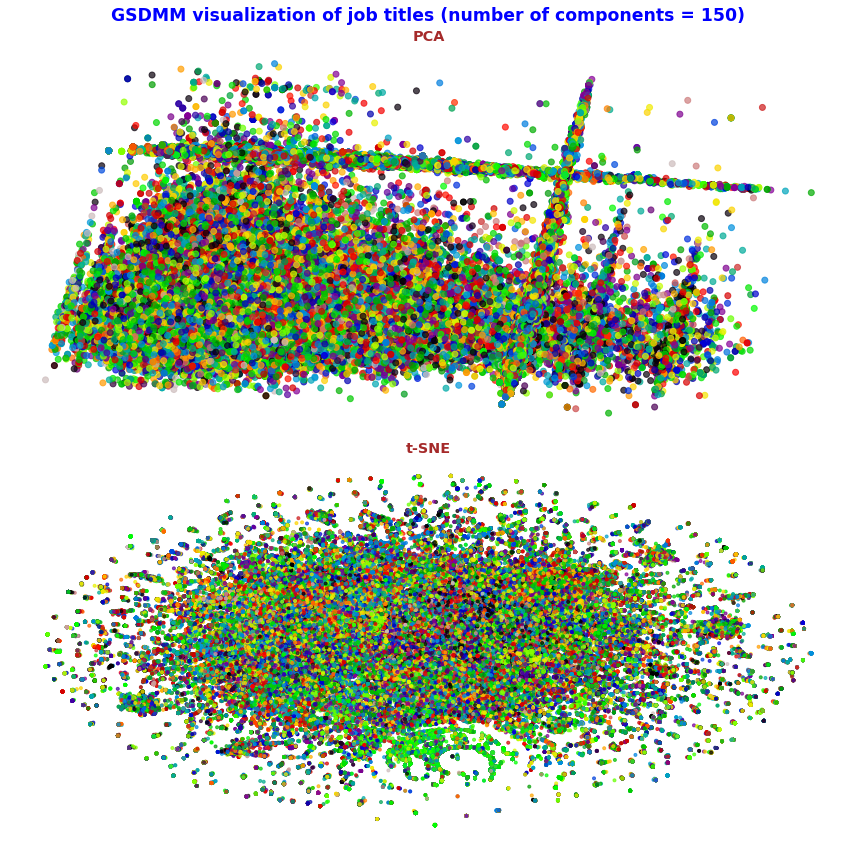

In [55]:
plot_title = f"GSDMM visualization of job titles (number of components = {best_n})"
palette = sns.color_palette("hls", as_cmap=True)
colors = cm.nipy_spectral(np.asarray(best_labels).astype(float) / best_n)

# Visualize clusters with PCA and t-SNE
visualize_cluster(
    plot_title,
    (12, 12),
    colors,
    palette,
    pca_datapoint,
    tsne_datapoint,
    None,
    pca=True,
    tsne=True,
    mds=False
)

## Save cluster results to file

In [56]:
np.save(OUTPUT_DIR + "gsdmm/" + "job-skills_gsdmm-clusters.csv", best_labels)

In [68]:
tsne_datapoint = None
pca_datapoint = None